# Models Comparison for TinyML

In [29]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [30]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
choosenIndex = 0

In [31]:
with open('data/X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [46]:
n_labels = 2 + choosenIndex
samples = 150
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [47]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [48]:
y = np.array([int(el) for el in y])
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test)
print(y_test.shape)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[[1681.61 1793.95 1284.47  688.31  831.26  326.18  198.29  185.82   80.8
   120.12   73.22  118.04  192.28  194.27  315.88  310.18  335.88  414.11
   434.93  338.98  266.97  308.11  283.55  275.53  331.38  402.95  195.61
   377.56  174.6   100.59   93.3   162.98]
 [1146.01 1995.76 2296.28 2049.1  1824.41 1645.48 1476.07 1203.49 1152.23
   550.19  211.05  243.95  253.25  235.52  245.71  153.87  158.24  123.83
   103.55   39.04   46.68   34.29   51.92   31.7   120.94   75.64   96.03
    42.45   76.5   174.95  163.42  119.99]
 [1473.04 2135.31 1910.89 2114.22 1961.72 2522.15 2194.22 1581.67 2193.98
  2572.83 2253.28  680.13  309.38  236.37  120.15  137.79   69.64   63.77
    24.43   25.14  101.39   68.47   91.94   92.24   87.96  114.5   130.06
   123.63  152.26  102.42  157.31  113.33]
 [1649.02 1464.62  913.96  928.75  401.29  260.13  285.68  253.72  314.22
   385.07  386.46  462.89  524.19  468.13  402.8   323.76  295.94  197.64
    98.44   62.97  229.19  165.9   269.29  215.75  240.68 

In [50]:
X_test.shape

(60, 32)

## Model Spotting

In [51]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'

In [52]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))


In [53]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_train = scaler.fit_transform(X_cross_train)
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        X_cross_test = scaler.transform(X_cross_test)
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,61 0,08
LR - 0,67 0,11
CART - 0,75 0,11
SVC - 0,79 0,06
RF - 0,83 0,05


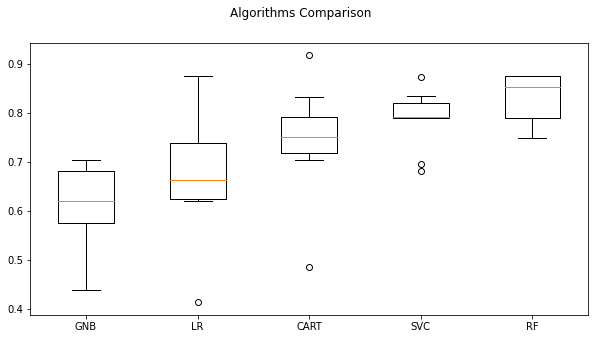

In [54]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [58]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv("classificationReport" + tasks[choosenIndex]+ '/'+'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.70      0.87      0.78        30
           1       0.83      0.63      0.72        30

    accuracy                           0.75        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.76      0.75      0.75        60



FileNotFoundError: [Errno 2] No such file or directory: '2Labels/classification_reportGNB.csv'

## Valutazione Inferance Rate medio (|X_test| = 40)

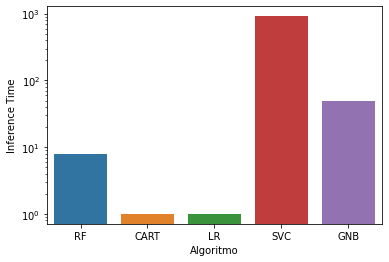

In [17]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

## Memoria occupata

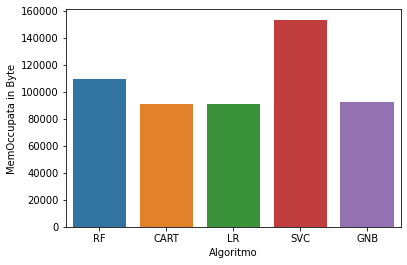

In [18]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [96]:
EPOCHS = 1000 #if labels == 3 else 500
BATCH_SIZE = 4
learn_rate = 0.00007 if labels == 3 else 0.0001
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [83]:
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 771       
Total params: 10,275
Trainable params: 10,275
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
41/41 [==============================] - 0s 1ms/step - loss: 1.0674 - accuracy: 0.4136
Epoch 2/500
41/4

KeyboardInterrupt: 

## Train and Test

In [97]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 514       
Total params: 10,018
Trainable params: 10,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.5167 - val_loss: 0.7

45/45 [==============================] - 0s 784us/step - loss: 0.3416 - accuracy: 0.8667 - val_loss: 0.5797 - val_accuracy: 0.7333
Epoch 107/1000
45/45 [==============================] - 0s 770us/step - loss: 0.3575 - accuracy: 0.8111 - val_loss: 0.5796 - val_accuracy: 0.7333
Epoch 108/1000
45/45 [==============================] - 0s 792us/step - loss: 0.3689 - accuracy: 0.8667 - val_loss: 0.5716 - val_accuracy: 0.7167
Epoch 109/1000
45/45 [==============================] - 0s 798us/step - loss: 0.3537 - accuracy: 0.8556 - val_loss: 0.5814 - val_accuracy: 0.7333
Epoch 110/1000
45/45 [==============================] - 0s 753us/step - loss: 0.3592 - accuracy: 0.8444 - val_loss: 0.5881 - val_accuracy: 0.7333
Epoch 111/1000
45/45 [==============================] - 0s 827us/step - loss: 0.3639 - accuracy: 0.8389 - val_loss: 0.5927 - val_accuracy: 0.7333
Epoch 112/1000
45/45 [==============================] - 0s 758us/step - loss: 0.3180 - accuracy: 0.8556 - val_loss: 0.5956 - val_accuracy: 

45/45 [==============================] - 0s 831us/step - loss: 0.2214 - accuracy: 0.9167 - val_loss: 0.6797 - val_accuracy: 0.7000
Epoch 219/1000
45/45 [==============================] - 0s 843us/step - loss: 0.2590 - accuracy: 0.8833 - val_loss: 0.6775 - val_accuracy: 0.7000
Epoch 220/1000
45/45 [==============================] - 0s 820us/step - loss: 0.2252 - accuracy: 0.9111 - val_loss: 0.6813 - val_accuracy: 0.7000
Epoch 221/1000
45/45 [==============================] - 0s 786us/step - loss: 0.2870 - accuracy: 0.8944 - val_loss: 0.6839 - val_accuracy: 0.7000
Epoch 222/1000
45/45 [==============================] - 0s 813us/step - loss: 0.3101 - accuracy: 0.8722 - val_loss: 0.6942 - val_accuracy: 0.6833
Epoch 223/1000
45/45 [==============================] - 0s 834us/step - loss: 0.2711 - accuracy: 0.9056 - val_loss: 0.7034 - val_accuracy: 0.6833
Epoch 224/1000
45/45 [==============================] - 0s 779us/step - loss: 0.2678 - accuracy: 0.8944 - val_loss: 0.7099 - val_accuracy: 

45/45 [==============================] - 0s 770us/step - loss: 0.2012 - accuracy: 0.9111 - val_loss: 0.7878 - val_accuracy: 0.6667
Epoch 331/1000
45/45 [==============================] - 0s 720us/step - loss: 0.1617 - accuracy: 0.9500 - val_loss: 0.7936 - val_accuracy: 0.6500
Epoch 332/1000
45/45 [==============================] - 0s 786us/step - loss: 0.2103 - accuracy: 0.9278 - val_loss: 0.8079 - val_accuracy: 0.6500
Epoch 333/1000
45/45 [==============================] - 0s 734us/step - loss: 0.1831 - accuracy: 0.9556 - val_loss: 0.8183 - val_accuracy: 0.6500
Epoch 334/1000
45/45 [==============================] - 0s 820us/step - loss: 0.1907 - accuracy: 0.9500 - val_loss: 0.8142 - val_accuracy: 0.6667
Epoch 335/1000
45/45 [==============================] - 0s 751us/step - loss: 0.2109 - accuracy: 0.9167 - val_loss: 0.8088 - val_accuracy: 0.6667
Epoch 336/1000
45/45 [==============================] - 0s 772us/step - loss: 0.2124 - accuracy: 0.9167 - val_loss: 0.8042 - val_accuracy: 

45/45 [==============================] - 0s 760us/step - loss: 0.1635 - accuracy: 0.9444 - val_loss: 0.8508 - val_accuracy: 0.6667
Epoch 443/1000
45/45 [==============================] - 0s 747us/step - loss: 0.1711 - accuracy: 0.9389 - val_loss: 0.8614 - val_accuracy: 0.6667
Epoch 444/1000
45/45 [==============================] - 0s 820us/step - loss: 0.1410 - accuracy: 0.9667 - val_loss: 0.8676 - val_accuracy: 0.6667
Epoch 445/1000
45/45 [==============================] - 0s 779us/step - loss: 0.1416 - accuracy: 0.9556 - val_loss: 0.8803 - val_accuracy: 0.6667
Epoch 446/1000
45/45 [==============================] - 0s 777us/step - loss: 0.1937 - accuracy: 0.9000 - val_loss: 0.8893 - val_accuracy: 0.6667
Epoch 447/1000
45/45 [==============================] - 0s 789us/step - loss: 0.1474 - accuracy: 0.9500 - val_loss: 0.8939 - val_accuracy: 0.6667
Epoch 448/1000
45/45 [==============================] - 0s 798us/step - loss: 0.1684 - accuracy: 0.9444 - val_loss: 0.8994 - val_accuracy: 

45/45 [==============================] - 0s 851us/step - loss: 0.1280 - accuracy: 0.9389 - val_loss: 0.9652 - val_accuracy: 0.6500
Epoch 555/1000
45/45 [==============================] - 0s 747us/step - loss: 0.1752 - accuracy: 0.9222 - val_loss: 0.9757 - val_accuracy: 0.6667
Epoch 556/1000
45/45 [==============================] - 0s 767us/step - loss: 0.1248 - accuracy: 0.9667 - val_loss: 0.9726 - val_accuracy: 0.6500
Epoch 557/1000
45/45 [==============================] - 0s 766us/step - loss: 0.0884 - accuracy: 0.9722 - val_loss: 0.9740 - val_accuracy: 0.6667
Epoch 558/1000
45/45 [==============================] - 0s 749us/step - loss: 0.1387 - accuracy: 0.9500 - val_loss: 0.9898 - val_accuracy: 0.6667
Epoch 559/1000
45/45 [==============================] - 0s 727us/step - loss: 0.1376 - accuracy: 0.9611 - val_loss: 0.9839 - val_accuracy: 0.6667
Epoch 560/1000
45/45 [==============================] - 0s 751us/step - loss: 0.1791 - accuracy: 0.9111 - val_loss: 0.9871 - val_accuracy: 

45/45 [==============================] - 0s 781us/step - loss: 0.0807 - accuracy: 0.9778 - val_loss: 1.0550 - val_accuracy: 0.6500
Epoch 667/1000
45/45 [==============================] - 0s 771us/step - loss: 0.1279 - accuracy: 0.9444 - val_loss: 1.0396 - val_accuracy: 0.6500
Epoch 668/1000
45/45 [==============================] - 0s 764us/step - loss: 0.1268 - accuracy: 0.9611 - val_loss: 1.0444 - val_accuracy: 0.6667
Epoch 669/1000
45/45 [==============================] - 0s 727us/step - loss: 0.1132 - accuracy: 0.9500 - val_loss: 1.0510 - val_accuracy: 0.6667
Epoch 670/1000
45/45 [==============================] - 0s 756us/step - loss: 0.1144 - accuracy: 0.9722 - val_loss: 1.0522 - val_accuracy: 0.6500
Epoch 671/1000
45/45 [==============================] - 0s 758us/step - loss: 0.1476 - accuracy: 0.9389 - val_loss: 1.0878 - val_accuracy: 0.6500
Epoch 672/1000
45/45 [==============================] - 0s 756us/step - loss: 0.1175 - accuracy: 0.9611 - val_loss: 1.0842 - val_accuracy: 

45/45 [==============================] - 0s 765us/step - loss: 0.1143 - accuracy: 0.9611 - val_loss: 1.1129 - val_accuracy: 0.6667
Epoch 779/1000
45/45 [==============================] - 0s 801us/step - loss: 0.1009 - accuracy: 0.9667 - val_loss: 1.0949 - val_accuracy: 0.6667
Epoch 780/1000
45/45 [==============================] - 0s 810us/step - loss: 0.1190 - accuracy: 0.9444 - val_loss: 1.1306 - val_accuracy: 0.6667
Epoch 781/1000
45/45 [==============================] - 0s 786us/step - loss: 0.0881 - accuracy: 0.9778 - val_loss: 1.1359 - val_accuracy: 0.6667
Epoch 782/1000
45/45 [==============================] - 0s 717us/step - loss: 0.0721 - accuracy: 0.9611 - val_loss: 1.1398 - val_accuracy: 0.6667
Epoch 783/1000
45/45 [==============================] - 0s 741us/step - loss: 0.0579 - accuracy: 0.9889 - val_loss: 1.1361 - val_accuracy: 0.6667
Epoch 784/1000
45/45 [==============================] - 0s 779us/step - loss: 0.0887 - accuracy: 0.9722 - val_loss: 1.1092 - val_accuracy: 

45/45 [==============================] - 0s 772us/step - loss: 0.0886 - accuracy: 0.9778 - val_loss: 1.2972 - val_accuracy: 0.6333
Epoch 891/1000
45/45 [==============================] - 0s 763us/step - loss: 0.0744 - accuracy: 0.9722 - val_loss: 1.3074 - val_accuracy: 0.6333
Epoch 892/1000
45/45 [==============================] - 0s 736us/step - loss: 0.0939 - accuracy: 0.9778 - val_loss: 1.2869 - val_accuracy: 0.6500
Epoch 893/1000
45/45 [==============================] - 0s 864us/step - loss: 0.1072 - accuracy: 0.9722 - val_loss: 1.2952 - val_accuracy: 0.6500
Epoch 894/1000
45/45 [==============================] - 0s 827us/step - loss: 0.0524 - accuracy: 0.9778 - val_loss: 1.2844 - val_accuracy: 0.6500
Epoch 895/1000
45/45 [==============================] - 0s 768us/step - loss: 0.0877 - accuracy: 0.9778 - val_loss: 1.2807 - val_accuracy: 0.6500
Epoch 896/1000
45/45 [==============================] - 0s 808us/step - loss: 0.0822 - accuracy: 0.9667 - val_loss: 1.2838 - val_accuracy: 

In [98]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
print(classification_report(y_test, predictions_categorical))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        30
           1       0.77      0.77      0.77        30

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



# Export Models in C code

In [99]:
# Neural network with TinyMLGen
with open('exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = 'exportedModels/' + str(labels) + "/"
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmpkrejdlcu/assets


INFO:tensorflow:Assets written to: /tmp/tmpkrejdlcu/assets
